In [1]:
pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 12.5 MB/s eta 0:00:00


In [2]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import re
import warnings
import numpy as np
import torch
import torch.nn as nn
import numpy as np
import evaluate
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud
from sklearn.utils.class_weight import compute_class_weight
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
from sklearn.model_selection import train_test_split
from datasets import Dataset
import torch # Added torch import
warnings.filterwarnings('ignore')

#**DATA PREPARATION**

In [4]:
df = pd.read_csv('tokped_scrap.csv')

In [5]:
df.head()

,content,score
0,tokopedia diambang kebangkrutan kali ya.. pese...,2
1,ok,5
2,"spam iklan produk tapaxco, sudah di report tet...",1
3,excelensi sangat bagus,5
4,bagus,5


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  10000 non-null  object
 1   score    10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [7]:
df.describe()

,score
count,10000.000000
mean,3.073400
std,1.857891
min,1.000000
25%,1.000000
50%,3.000000
75%,5.000000
max,5.000000


In [8]:
df['content'].value_counts()

,count
content,
mantap,239
ok,223
bagus,203
good,130
oke,62
...,...
"beli barang yang datang kosong tidak ada barang nya, sudah komplen dengan bukti jelas tapi di persulit sama Tokopedia. di suruh balikin barang oleh pihak aplikasi nya biar dana kembali sudah gua balikin barang nyampe ke penjual sudah 3 hari yg lalu tp harus korfirmasi di terima oleh penjual, pihak penjual gak di konfirmasi2. dana gua gak kembali2. cukup terakhir dah beli d sini.",1
"Saya suka Tokopedia sudah ratusan kali transaksi yaa 😄😄 gak ada kendala, sukses terus tokopedia.... tapi lama lama harga barang beda, bisa lebih murah di apk sebelah kenapa ya padahal barang dan tipe sama yg di jual",1
ini kenapa pas habis verifikasi pin ngestuck ya,1


In [9]:
kamus_slang = {
    ' apl ': 'aplikasi', ' krn ': 'karena', ' gk ': 'tidak', ' knk ': 'mengalami', ' skrg ': 'sekarang',
    ' bgs ': 'bagus', 'bgt ': 'banget', ' lemot ': 'lama', ' lynan ': 'layanan', ' yg ': 'yang', ' kyk ': 'seperti',
    ' jg ': 'juga', ' orng ': 'orang', ' skrng ': 'sekarang', ' jlk ': 'jelek', ' dgn ': 'dengan', ' lg ': 'lagi',
    ' wkwkwk ': 'tertawa', ' blm ': 'belum', ' km ': 'kamu', ' mrk ': 'mereka', ' mantaap ': 'mantap', ' ramh ': 'ramah',
    ' gaaa ': 'tidak', ' simpn ': 'simpan', ' apl ': 'aplikasi', ' mdh ': 'mudah', ' ulng ': 'ulang', ' tpt ': 'tepat',
    ' bntu ': 'bantu', ' truss ': 'terus', ' tb ': 'tiba', ' ilangg ': 'hilang', ' ngilangin ': 'menghilangkan',
    ' klw ': 'kalau', ' psn ': 'pesan', ' gtu ': 'gitu', ' aq ': 'aku', ' tp ': 'tapi', ' jelle ': 'jelek',
    ' hrs ': 'harus', ' mantepp ': 'mantap', ' sy ': 'saya', ' ngelek ': 'lambat', ' kwalitas ': 'kualitas',
    ' detek ': 'deteksi', ' uda ': 'udah', ' cpt ': 'cepat', 'yg' : 'yang'
}

def normalize_slang(text):
    words = text.split()
    normalized_words = [kamus_slang.get(word, word) for word in words]
    return ' '.join(normalized_words)

In [10]:
import emoji

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#(\w+)", r"\1", text)
    text = re.sub(r"[^A-Za-zÀ-ÿ0-9\s.,!?]", " ", text)
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = text.encode('ascii', 'ignore').decode('ascii')
    text = normalize_slang(text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


df['clean_text'] = df['content'].apply(clean_text)

In [11]:
list_positif = {
    'bagus', 'puas', 'cepat', 'rekomendasi', 'baik', 'cocok', 'original', 'ori',
    'terbaik', 'keren', 'jempol', 'oke', 'ok', 'sesuai', 'murah', 'berfungsi',
    'terima', 'kasih', 'mantap', 'rapi', 'aman', 'handal', 'mantul', 'top',
    'lancar', 'kualitas', 'nyaman', 'suka', 'favorit', 'memuaskan', 'hemat',
    'praktis', 'tepat', 'lengkap', 'bagus banget', 'sangat puas', 'super', 'rekomended',
    'mantap jiwa', 'oke banget', 'puas banget', 'cepat sampai', 'packing aman',
    'harga bersahabat', 'worth it', 'respon cepat', 'friendly', 'excellent', 'original banget',
    'nice', 'top markotop', 'terpercaya', 'recommend', 'nice banget', 'fast', 'awesome',
    'memuaskan banget', 'selalu puas', 'original ori', 'mantap produk', 'mantap sekali',
    'rekomendasi banget', 'bagus ori', 'oke ori', 'ok ori', 'sangat bagus', 'puas ori',
    'lancar banget', 'nyaman banget', 'mantap kualitas', 'ok mantap', 'oke mantap',
    'original mantap', 'mantap jiwa', 'top banget', 'super mantap', 'mantul banget',
    'recommended', 'value for money', 'worth every penny', 'fast delivery', 'safe packing',
    'quality', 'excellent product', 'very good', 'amazing', 'perfect', 'happy', 'loved',
    'high quality', 'solid', 'durable', 'reliable', 'good condition', 'smooth', 'impressive',
    'satisfying', 'wonderful', 'best choice', 'great', 'fantastic', 'awesome product', 'okey'
}
list_negatif = {
    'kecewa', 'jelek', 'rusak', 'lama', 'salah', 'cacat', 'bohong', 'tipu',
    'lambat', 'pecah', 'bocor', 'buruk', 'parah', 'menyesal', 'tidak',
    'kurang', 'belum', 'sampai', 'tidak sesuai', 'minus', 'lemah', 'ringkih',
    'gagal', 'cacat total', 'malas', 'kurang puas', 'retur', 'refund', 'kacau',
    'tidak lengkap', 'paket hilang', 'packing jelek', 'kapok', 'gagal kirim',
    'terlambat', 'barang hilang', 'tidak original', 'palus', 'tidak oke', 'tidak memuaskan',
    'rusak parah', 'tidak berfungsi', 'jelek banget', 'parah banget', 'sampai rusak',
    'tidak sampai', 'lambat banget', 'tidak rapi', 'buruk sekali', 'tidak nyaman',
    'menyesal beli', 'cacat minor', 'tidak sesuai deskripsi', 'packing buruk', 'kualitas rendah',
    'tidak memuaskan', 'delay', 'tidak cocok', 'barang salah', 'problem', 'defect', 'disappointed',
    'fail', 'waste', 'poor', 'broken', 'fake', 'bad', 'awful', 'terrible', 'worst', 'unhappy',
    'complaint', 'frustrated', 'unsatisfied', 'issue', 'problematic', 'slow', 'damaged', 'lost',
    'missing', 'defective', 'scam', 'ripoff', 'fraud', 'misleading', 'displeased', 'angry',
    'annoyed', 'regret', 'dissatisfied', 'inferior', 'horrible', 'unacceptable', 'sucks', 'hate',
    'trash', 'messy', 'poor quality', 'not recommended', 'useless', 'worthless', 'damaging', 'unreliable'
}

In [12]:
def label_by_lexicon(text):
    words = set(text.split())
    score_pos = len(words.intersection(list_positif))
    score_neg = len(words.intersection(list_negatif))

    if score_pos > score_neg:
        return 'positif'
    elif score_neg > score_pos:
        return 'negatif'
    else:
        return 'netral'

df['sentiment'] = df['clean_text'].apply(label_by_lexicon)

print("\nDistribusi Kelas Sentimen (BARU - Lexicon):")
print(df['sentiment'].value_counts())


Distribusi Kelas Sentimen (BARU - Lexicon):
sentiment
netral     4690
positif    2993
negatif    2317
Name: count, dtype: int64


In [13]:
df.head()

,content,score,clean_text,sentiment
0,tokopedia diambang kebangkrutan kali ya.. pese...,2,tokopedia diambang kebangkrutan kali ya.. pese...,negatif
1,ok,5,ok,positif
2,"spam iklan produk tapaxco, sudah di report tet...",1,"spam iklan produk tapaxco, sudah di report tet...",netral
3,excelensi sangat bagus,5,excelensi sangat bagus,positif
4,bagus,5,bagus,positif


In [14]:
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['sentiment']
)

In [15]:
train_df['sentiment'].value_counts(), test_df['sentiment'].value_counts()

(sentiment
 netral     3752
 positif    2394
 negatif    1854
 Name: count, dtype: int64,
 sentiment
 netral     938
 positif    599
 negatif    463
 Name: count, dtype: int64)

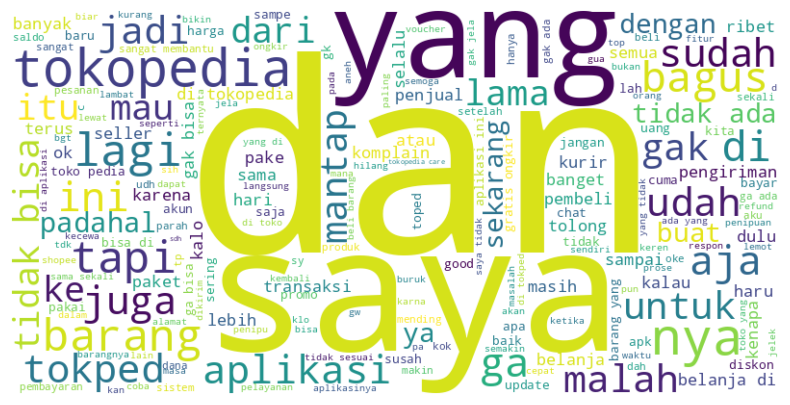

In [16]:
all_text = ' '.join(df['clean_text'])
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate(all_text)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#**DATA TRANFORMATION**




In [17]:
model_name = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
label_map = {'negatif': 0, 'netral': 1, 'positif': 2}
train_df['labels'] = train_df['sentiment'].map(label_map)
test_df['labels'] = test_df['sentiment'].map(label_map)

In [19]:
train_dataset = Dataset.from_pandas(train_df[['content', 'labels']])
test_dataset = Dataset.from_pandas(test_df[['content', 'labels']])

def tokenize_function(examples):
    return tokenizer(examples["content"], padding="max_length", truncation=True)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

tokenized_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
tokenized_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [20]:
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

#**MODELING**

**TRAIN SKEMA 1**

In [21]:
output_dir_skema_1 = "./results_skema_1"

training_args = TrainingArguments(
    output_dir=output_dir_skema_1,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs_skema_1",
    logging_steps=100,
    report_to="none",
)

print("TrainingArguments untuk Skema 1 (LR 5e-5) siap.")

TrainingArguments untuk Skema 1 (LR 5e-5) siap.


In [22]:
trainer_skema_1 = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [23]:
trainer_skema_1.train()

train_metrics_1 = trainer_skema_1.evaluate(tokenized_train)
test_metrics_1 = trainer_skema_1.evaluate(tokenized_test)
print(f"Akurasi Training (Skema 1): {train_metrics_1['eval_accuracy']:.2%}")
print(f"Akurasi Testing (Skema 1): {test_metrics_1['eval_accuracy']:.2%}")

Epoch,Training Loss,Validation Loss,Accuracy
1,0.288000,0.289663,0.924500
2,0.180900,0.182730,0.936500
3,0.109400,0.142802,0.967500


Akurasi Training (Skema 1): 98.55%
Akurasi Testing (Skema 1): 96.75%


**TRAIN SKEMA 2**

In [24]:
output_dir_skema_2 = "./results_skema_2"

training_args_skema_2 = TrainingArguments(
    output_dir=output_dir_skema_2,
    learning_rate=2e-5,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs_skema_2",
    report_to="none",
)

In [25]:
model_2 = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

trainer_skema_2 = Trainer(
    model=model_2,
    args=training_args_skema_2,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
trainer_skema_2.train()

train_metrics_2 = trainer_skema_2.evaluate(tokenized_train)
test_metrics_2 = trainer_skema_2.evaluate(tokenized_test)

print(f"Akurasi Training (Skema 2): {train_metrics_2['eval_accuracy']:.2%}")
print(f"Akurasi Testing (Skema 2): {test_metrics_2['eval_accuracy']:.2%}")

Epoch,Training Loss,Validation Loss,Accuracy
1,0.535600,0.251239,0.923000
2,0.172200,0.138817,0.963500
3,0.108200,0.109170,0.972000
4,0.059200,0.131302,0.970000
5,0.033200,0.134918,0.971500


Akurasi Training (Skema 2): 98.66%
Akurasi Testing (Skema 2): 97.20%


**TRAIN SKEMA 3**

In [27]:
label_map = {'negatif': 0, 'netral': 1, 'positif': 2}

train_df_skema3, test_df_skema3 = train_test_split(
    df,
    test_size=0.3,
    random_state=42,
    stratify=df['sentiment']
)

train_df_skema3["labels"] = train_df_skema3["sentiment"].map(label_map)
test_df_skema3["labels"] = test_df_skema3["sentiment"].map(label_map)

ds_train_3 = Dataset.from_pandas(train_df_skema3[["content", "labels"]])
ds_test_3 = Dataset.from_pandas(test_df_skema3[["content", "labels"]])

tokenized_train_3 = ds_train_3.map(tokenize_function, batched=True)
tokenized_test_3 = ds_test_3.map(tokenize_function, batched=True)

tokenized_train_3.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
tokenized_test_3.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [28]:
output_dir_skema_3 = "./results_skema_3"

training_args_skema_3 = TrainingArguments(
    output_dir=output_dir_skema_3,
    learning_rate=5e-5,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs_skema_3",
    report_to="none",
)

In [29]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

trainer_skema_3 = Trainer(
    model=model,
    args=training_args_skema_3,
    train_dataset=tokenized_train_3,
    eval_dataset=tokenized_test_3,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
trainer_skema_3.train()

train_metrics_3 = trainer_skema_3.evaluate(tokenized_train_3)
test_metrics_3 = trainer_skema_3.evaluate(tokenized_test_3)

print(f"Akurasi Training (Skema 3): {train_metrics_3['eval_accuracy']:.2%}")
print(f"Akurasi Testing (Skema 3): {test_metrics_3['eval_accuracy']:.2%}")

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.254518,0.919000
2,0.445000,0.227384,0.940333
3,0.204900,0.156548,0.960333
4,0.128100,0.183776,0.961333
5,0.069100,0.151530,0.969667


Akurasi Training (Skema 3): 99.49%
Akurasi Testing (Skema 3): 96.97%


#**EVALUASI DAN TESTING**

In [31]:
target_names = ['negatif', 'netral', 'positif']


--- CLASSIFICATION REPORT (SKEMA 1) ---
              precision    recall  f1-score   support

     negatif       0.96      0.97      0.96       463
      netral       0.96      0.97      0.97       938
     positif       0.99      0.96      0.97       599

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000


--- CONFUSION MATRIX (SKEMA 1) ---


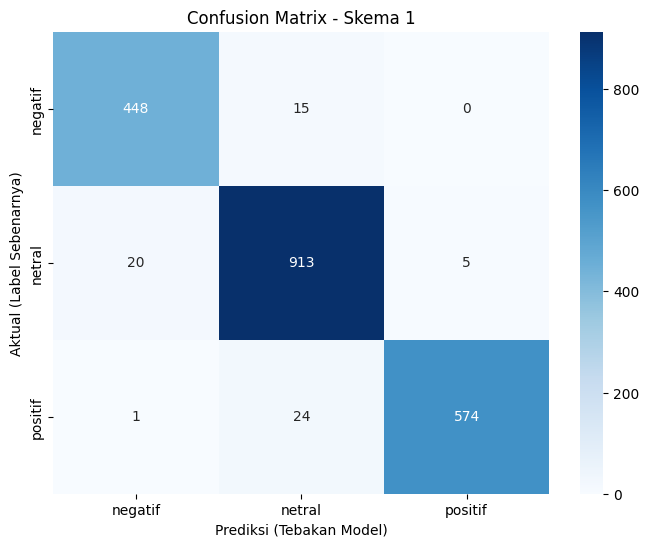

In [32]:
predictions_output_1 = trainer_skema_1.predict(tokenized_test)

y_pred_logits_1 = predictions_output_1.predictions
y_true_1 = predictions_output_1.label_ids

y_pred_1 = np.argmax(y_pred_logits_1, axis=-1)

print("\n--- CLASSIFICATION REPORT (SKEMA 1) ---")
print(classification_report(y_true_1, y_pred_1, target_names=target_names))

print("\n--- CONFUSION MATRIX (SKEMA 1) ---")
cm_1 = confusion_matrix(y_true_1, y_pred_1)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.ylabel('Aktual (Label Sebenarnya)')
plt.xlabel('Prediksi (Tebakan Model)')
plt.title('Confusion Matrix - Skema 1')
plt.show()


--- CLASSIFICATION REPORT (SKEMA 2) ---
              precision    recall  f1-score   support

     negatif       0.96      0.97      0.96       463
      netral       0.97      0.97      0.97       938
     positif       0.99      0.97      0.98       599

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000


--- CONFUSION MATRIX (SKEMA 2) ---


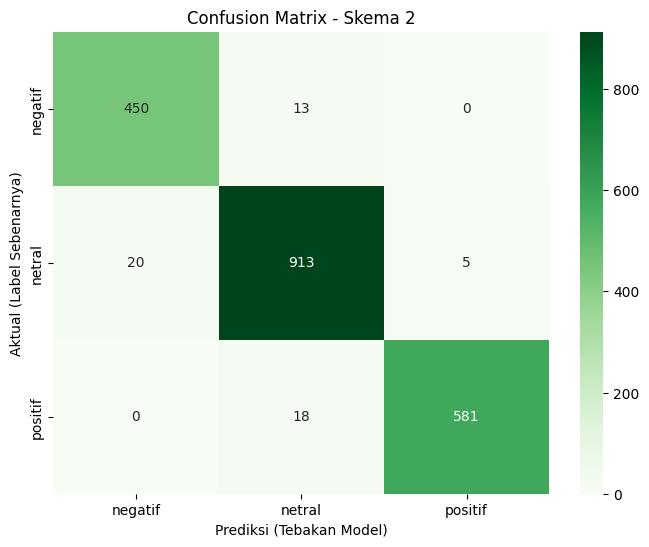

In [33]:
# --- SKEMA 2 ---
predictions_output_2 = trainer_skema_2.predict(tokenized_test)

y_pred_logits_2 = predictions_output_2.predictions
y_true_2 = predictions_output_2.label_ids

y_pred_2 = np.argmax(y_pred_logits_2, axis=-1)

print("\n--- CLASSIFICATION REPORT (SKEMA 2) ---")
print(classification_report(y_true_2, y_pred_2, target_names=target_names))

print("\n--- CONFUSION MATRIX (SKEMA 2) ---")
cm_2 = confusion_matrix(y_true_2, y_pred_2)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names,
            yticklabels=target_names)
plt.ylabel('Aktual (Label Sebenarnya)')
plt.xlabel('Prediksi (Tebakan Model)')
plt.title('Confusion Matrix - Skema 2')
plt.show()


--- CLASSIFICATION REPORT (SKEMA 3) ---
              precision    recall  f1-score   support

     negatif       0.96      0.97      0.96       695
      netral       0.96      0.98      0.97      1407
     positif       0.99      0.96      0.98       898

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000


--- CONFUSION MATRIX (SKEMA 3) ---


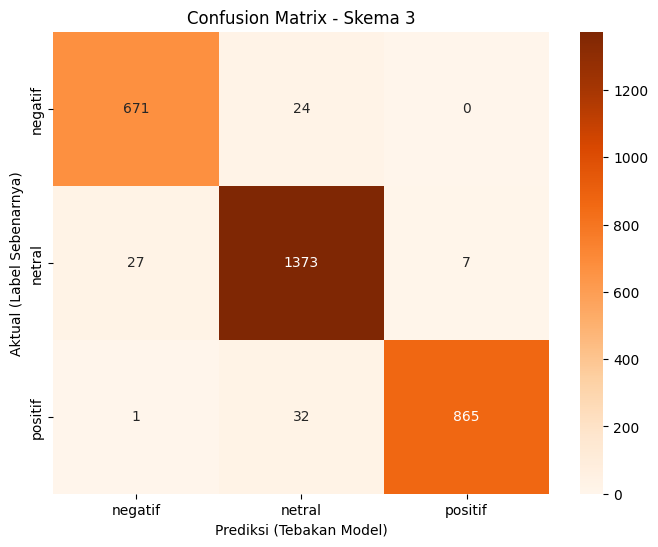

In [34]:
predictions_output_3 = trainer_skema_3.predict(tokenized_test_3)

y_pred_logits_3 = predictions_output_3.predictions
y_true_3 = predictions_output_3.label_ids

y_pred_3 = np.argmax(y_pred_logits_3, axis=-1)

print("\n--- CLASSIFICATION REPORT (SKEMA 3) ---")
print(classification_report(y_true_3, y_pred_3, target_names=target_names))

print("\n--- CONFUSION MATRIX (SKEMA 3) ---")
cm_3 = confusion_matrix(y_true_3, y_pred_3)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_3, annot=True, fmt='d', cmap='Oranges',
            xticklabels=target_names,
            yticklabels=target_names)
plt.ylabel('Aktual (Label Sebenarnya)')
plt.xlabel('Prediksi (Tebakan Model)')
plt.title('Confusion Matrix - Skema 3')
plt.show()

In [35]:
#Menyimpan model
model_terbaik_dir = "./results_skema_2"
trainer_skema_2.save_model(model_terbaik_dir)
tokenizer.save_pretrained(model_terbaik_dir)

!zip -r model_terbaik.zip ./model_terbaik_dir

	zip warning: name not matched: ./model_terbaik_dir

zip error: Nothing to do! (try: zip -r model_terbaik.zip . -i ./model_terbaik_dir)


In [36]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

labels_map = {'negatif': 0, 'netral': 1, 'positif': 2}
id2label = {0: 'negatif', 1: 'netral', 2: 'positif'}

model_terbaik_dir = "./results_skema_2"

model = AutoModelForSequenceClassification.from_pretrained(
    model_terbaik_dir,
    id2label=id2label,
    label2id=labels_map
)
tokenizer = AutoTokenizer.from_pretrained(model_terbaik_dir)

nlp = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer
)

teks_positif = "Barangnya bagus banget, pengiriman cepat, puas!"
teks_negatif = "Kecewa, produknya rusak pas sampai, jelek banget packingnya."
teks_netral = "barangnya biasa aja, pengiriman cepet"

for teks in [teks_positif, teks_negatif, teks_netral]:
    hasil = nlp(teks)[0]
    print(f"Kalimat: '{teks}'")
    print(f"Prediksi: {hasil['label']} (Skor: {hasil['score']:.4f})\n")

Device set to use cuda:0


Kalimat: 'Barangnya bagus banget, pengiriman cepat, puas!'
Prediksi: positif (Skor: 0.9988)

Kalimat: 'Kecewa, produknya rusak pas sampai, jelek banget packingnya.'
Prediksi: negatif (Skor: 0.9968)

Kalimat: 'barangnya biasa aja, pengiriman cepet'
Prediksi: netral (Skor: 0.9972)



In [37]:
model.save_pretrained("./results_skema_2")
tokenizer.save_pretrained("./results_skema_2")

('./results_skema_2/tokenizer_config.json',
 './results_skema_2/special_tokens_map.json',
 './results_skema_2/vocab.txt',
 './results_skema_2/added_tokens.json',
 './results_skema_2/tokenizer.json')